# Phase Locking Value

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import glob
from collections import defaultdict
import re

In [3]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
import itertools
from scipy.stats import linregress

In [4]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [32]:
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.signal import hilbert, butter, filtfilt

## Inputs & Data

Explanation of each input and where it comes from.

In [6]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case

In [7]:
BBOX_TO_ANCHOR=(1.5, 0.9)
LOC='upper right'

In [8]:
ALL_BANDS = ["theta", "beta", "gamma"]
BAND_TO_FREQ = {"theta": {"low_freq": 4, "high_freq": 12}, "beta": {"low_freq": 13, "high_freq": 30}, "gamma": {"low_freq": 30, "high_freq": 70}}

In [9]:
# variables for LFP extraction
FREQ_MIN=0.5
FREQ_MAX=300
NOTCH_FREQ=60
ORIGINAL_SAMPLE_RATE = 20000
RESAMPLE_RATE=1000
TRIAL_DURATION=10

In [10]:
INPUT_VARIABLE = 1

TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 3
TIME_WINDOW_STEP = 1.5 

TRIAL_TIME_STAMP_DURATION = 1000*10

In [11]:
BIN_TO_COLOR = {0: {"baseline": "lightblue", "trial": "blue"}, 1: {"baseline": "lightgreen", "trial": "green"}, 2: {"baseline": "lightcoral", "trial": "red"}}
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}
BIN_TO_VELOCITY = {0: "0 to 2.5cm/s", 1: "2.5 to 5cm/s", 2: "5cm/s+"}

In [12]:
NUM_LINES = 3

In [13]:
# Generate colors from the "Blues" colormap
LOSING_COLORS = cm.Oranges(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
WINNING_COLORS = cm.Blues(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
REWARDED_COLORS = cm.Greens(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
OMISSION_COLORS = cm.Reds(np.linspace(0.5, 1, NUM_LINES))

In [14]:
BASELINE_OUTCOME_TO_COLOR = {'lose': "orange",
'lose_baseline': LOSING_COLORS[0],
'omission': "red",
'omission_baseline': "hotpink",
'rewarded': "green",
'rewarded_baseline': REWARDED_COLORS[0],
'win': "blue",
'win_baseline': WINNING_COLORS[0],
'lose_comp': "orange", 
'lose_non_comp': "yellow",
'win_comp': "blue", 
'win_non_comp': WINNING_COLORS[0]}

In [15]:
COMPETITIVE_OUTCOME_TO_COLOR = {'lose_comp': "orange", 
'lose_non_comp': "yellow",
'omission': "red",
'rewarded': "green",
'win_comp': "blue", 
'win_non_comp': WINNING_COLORS[0]}

In [16]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [17]:
CHANNEL_MAPPING_DF = pd.read_excel("../../channel_mapping.xlsx")
CHANNEL_MAPPING_DF["Subject"] = CHANNEL_MAPPING_DF["Subject"].astype(str)

TONE_TIMESTAMP_DF = pd.read_excel("../../rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs


In [18]:
CHANNEL_MAPPING_DF = pd.read_excel("../../channel_mapping.xlsx")
CHANNEL_MAPPING_DF["Subject"] = CHANNEL_MAPPING_DF["Subject"].astype(str)

TONE_TIMESTAMP_DF = pd.read_excel("../../rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs


In [19]:
FULL_LFP_TRACES = pd.read_pickle("./proc/full_baseline_and_trial_lfp_traces.pkl")

In [20]:
FULL_LFP_TRACES = FULL_LFP_TRACES.drop_duplicates(subset=["recording_file", "time"], keep="first")

In [68]:
GROUPINGS = "trial_outcome"


## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions

- Ideally functions are defined here first and then data is processed using the functions
    - function names are short and in snake case all lowercase
    - a function name should be unique but does not have to describe the function
    - doc strings describe functions not function names

In [22]:
def generate_pairs(lst):
    pairs = []
    n = len(lst)
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((lst[i], lst[j]))
    return pairs

In [23]:
def nested_dict():
    return defaultdict(dict)

triple_nested_dict = defaultdict(nested_dict)

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [24]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

## Phase Locking Value

In [25]:
baseline_cols = FULL_LFP_TRACES.columns

In [26]:
brain_region_cols = [col for col in FULL_LFP_TRACES.columns if "spike_interface" in col]

In [27]:
brain_region_cols

['spike_interface_mPFC',
 'spike_interface_vHPC',
 'spike_interface_BLA',
 'spike_interface_LH',
 'spike_interface_MD']

In [28]:
baseline_pairs = generate_pairs(sorted([col for col in FULL_LFP_TRACES.columns if "baseline_lfp_trace" in col]))
trial_pairs = generate_pairs(sorted([col for col in FULL_LFP_TRACES.columns if "trial_lfp_trace" in col]))

In [29]:
baseline_pairs

[('BLA_baseline_lfp_trace', 'LH_baseline_lfp_trace'),
 ('BLA_baseline_lfp_trace', 'MD_baseline_lfp_trace'),
 ('BLA_baseline_lfp_trace', 'mPFC_baseline_lfp_trace'),
 ('BLA_baseline_lfp_trace', 'vHPC_baseline_lfp_trace'),
 ('LH_baseline_lfp_trace', 'MD_baseline_lfp_trace'),
 ('LH_baseline_lfp_trace', 'mPFC_baseline_lfp_trace'),
 ('LH_baseline_lfp_trace', 'vHPC_baseline_lfp_trace'),
 ('MD_baseline_lfp_trace', 'mPFC_baseline_lfp_trace'),
 ('MD_baseline_lfp_trace', 'vHPC_baseline_lfp_trace'),
 ('mPFC_baseline_lfp_trace', 'vHPC_baseline_lfp_trace')]

In [30]:
baseline_col = sorted([col for col in FULL_LFP_TRACES.columns if "baseline_lfp_trace" in col])
trial_col = sorted([col for col in FULL_LFP_TRACES.columns if "trial_lfp_trace" in col])

In [33]:
for region in baseline_col:
    FULL_LFP_TRACES["{}_phase".format(region.split("_lfp_")[0])] = FULL_LFP_TRACES[region].apply(lambda x: np.angle(hilbert(x)))
for region in trial_col:
    FULL_LFP_TRACES["{}_phase".format(region.split("_lfp_")[0])] = FULL_LFP_TRACES[region].apply(lambda x: np.angle(hilbert(x)))

In [35]:
baseline_pairs = generate_pairs(sorted([col for col in FULL_LFP_TRACES.columns if "baseline_phase" in col]))
trial_pairs = generate_pairs(sorted([col for col in FULL_LFP_TRACES.columns if "trial_phase" in col]))

In [36]:
baseline_pairs

[('BLA_baseline_phase', 'LH_baseline_phase'),
 ('BLA_baseline_phase', 'MD_baseline_phase'),
 ('BLA_baseline_phase', 'mPFC_baseline_phase'),
 ('BLA_baseline_phase', 'vHPC_baseline_phase'),
 ('LH_baseline_phase', 'MD_baseline_phase'),
 ('LH_baseline_phase', 'mPFC_baseline_phase'),
 ('LH_baseline_phase', 'vHPC_baseline_phase'),
 ('MD_baseline_phase', 'mPFC_baseline_phase'),
 ('MD_baseline_phase', 'vHPC_baseline_phase'),
 ('mPFC_baseline_phase', 'vHPC_baseline_phase')]

In [37]:
for region_1, region_2 in baseline_pairs:
    pair_base_name = "{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])
    print(pair_base_name)
    try:
        FULL_LFP_TRACES["{}_baseline_phase_diff".format(pair_base_name)] = FULL_LFP_TRACES.apply(lambda row: row[region_1] - row[region_2], axis=1 )
        FULL_LFP_TRACES["{}_baseline_plv".format(pair_base_name)] = FULL_LFP_TRACES["{}_baseline_phase_diff".format(pair_base_name)].apply(lambda x: [abs(np.mean(np.exp(1j * x[num*1000:num*1000+1000]))) for num in range(0,10)])
    
    except Exception as e: 
        print(e)
    

BLA_LH
BLA_MD
BLA_mPFC
BLA_vHPC
LH_MD
LH_mPFC
LH_vHPC
MD_mPFC
MD_vHPC
mPFC_vHPC


In [38]:
for region_1, region_2 in trial_pairs:
    pair_base_name = "{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])
    print(pair_base_name)
    try:
        FULL_LFP_TRACES["{}_trial_phase_diff".format(pair_base_name)] = FULL_LFP_TRACES.apply(lambda row: row[region_1] - row[region_2], axis=1 )
        FULL_LFP_TRACES["{}_trial_plv".format(pair_base_name)] = FULL_LFP_TRACES["{}_trial_phase_diff".format(pair_base_name)].apply(lambda x: [abs(np.mean(np.exp(1j * x[num*1000:num*1000+1000]))) for num in range(0,10)])
    
    except Exception as e: 
        print(e)
    

BLA_LH
BLA_MD
BLA_mPFC
BLA_vHPC
LH_MD
LH_mPFC
LH_vHPC
MD_mPFC
MD_vHPC
mPFC_vHPC


In [ ]:
FULL_LFP_TRACES = FULL_LFP_TRACES.drop(columns=["BLA_LH_trial_phase_locking_value"])

In [39]:
trial_plv_col = sorted([col for col in FULL_LFP_TRACES.columns if "trial_plv" in col])

In [41]:
trial_plv_col

['BLA_LH_trial_plv',
 'BLA_MD_trial_plv',
 'BLA_mPFC_trial_plv',
 'BLA_vHPC_trial_plv',
 'LH_MD_trial_plv',
 'LH_mPFC_trial_plv',
 'LH_vHPC_trial_plv',
 'MD_mPFC_trial_plv',
 'MD_vHPC_trial_plv',
 'mPFC_vHPC_trial_plv']

In [59]:
mean

array([0.32610938, 0.3495391 , 0.3652594 , 0.35441092, 0.37653655,
       0.3202569 , 0.31819242, 0.33829182, 0.37550798, 0.33831504,
       0.36661202, 0.3445253 , 0.32514983, 0.3643145 , 0.36366796,
       0.36291435, 0.35132003, 0.3432296 , 0.3090066 , 0.3259058 ],
      dtype=float32)

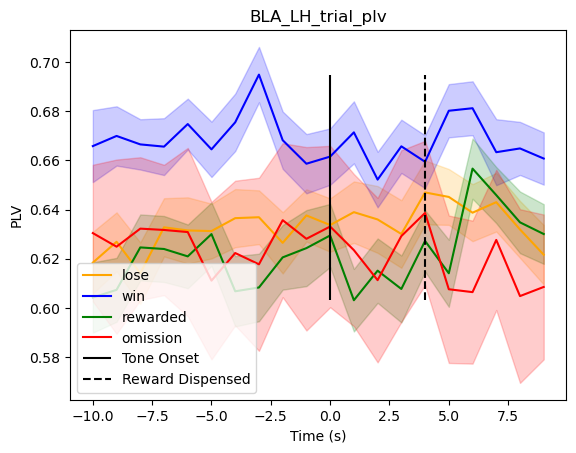

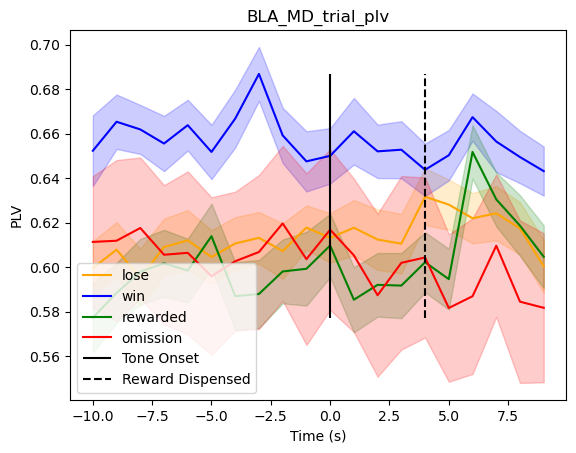

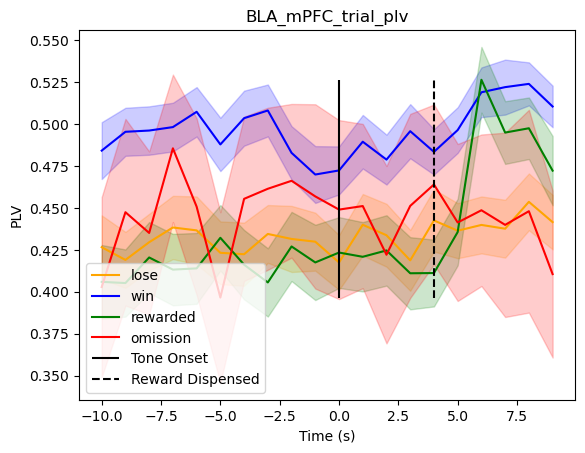

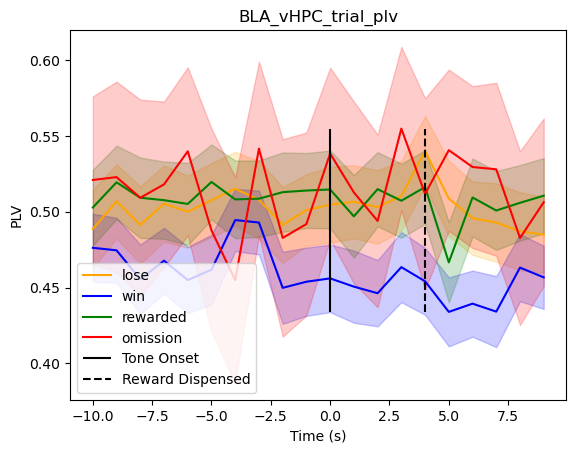

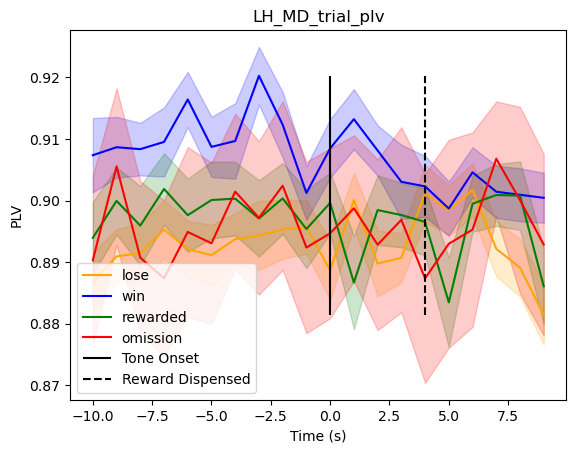

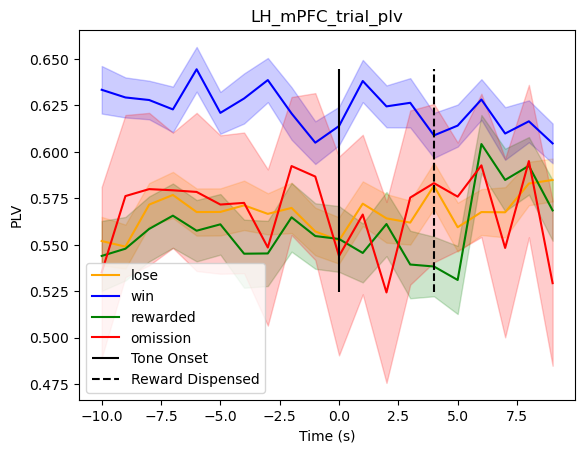

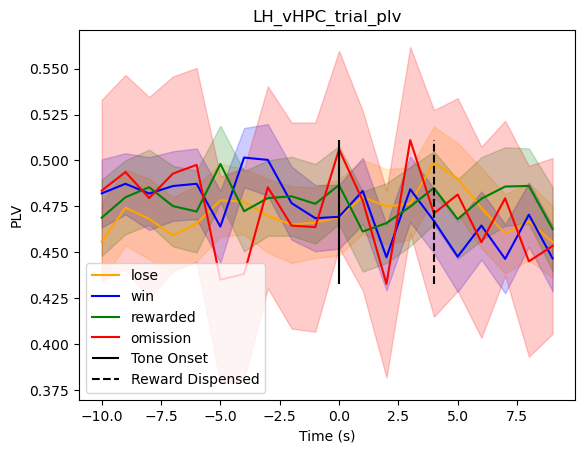

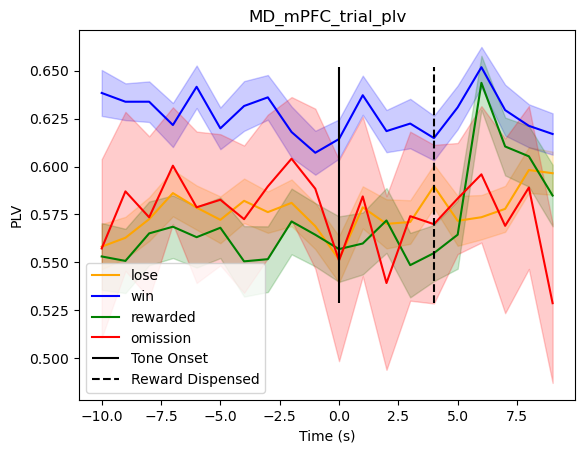

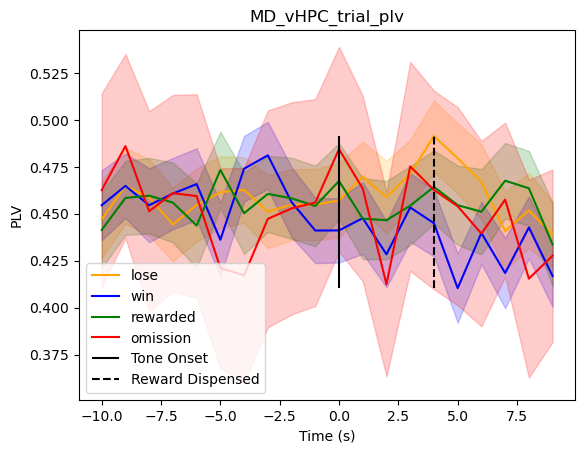

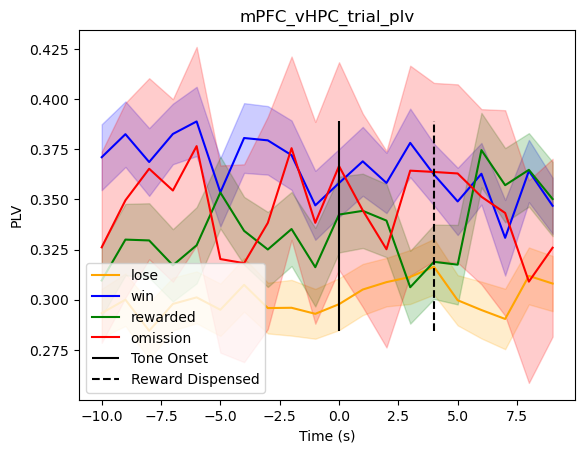

In [74]:
for baseline_col, trial_col in zip(baseline_plv_col, trial_plv_col):
    fig, ax = plt.subplots()
    current_max = 0
    current_min = 1
    for outcome in FULL_LFP_TRACES[GROUPINGS].unique():
        current_df = FULL_LFP_TRACES[(FULL_LFP_TRACES[GROUPINGS] == outcome)]
    
        # Stack all arrays vertically
        trial_arrays = np.vstack(current_df[trial_col].values)
        baseline_arrays = np.vstack(current_df[baseline_col].values)
        all_arrays = np.hstack([baseline_arrays, trial_arrays])
        
        mean = all_arrays.mean(axis=0) 
        # Compute the SEM for each index
        sem = all_arrays.std(axis=0) / np.sqrt(len(all_arrays))
        plt.plot(np.arange(-len(mean)//2, len(mean)//2), mean, label=outcome, color=BASELINE_OUTCOME_TO_COLOR[outcome])
        plt.fill_between(np.arange(-len(mean)//2, len(mean)//2), mean - sem, mean + sem, alpha=0.2, color=BASELINE_OUTCOME_TO_COLOR[outcome])
        if current_max <= mean.max():
            current_max = mean.max()
        if current_min >= mean.min():
            current_min = mean.min()
    
    # Making new ticks that are divisible by 10
    # x_ticks_range = np.arange(-len(mean), len(mean), FRAME_RATE)
    # plt.xticks(x_ticks_range)
    # Converting the x ticks into seconds
    labels = [item.get_text() for item in ax.get_xticklabels()]
    # new_labels = [str(int(label.replace('−', '-')) // FRAME_RATE)  for label in labels]
    # ax.set_xticklabels(new_labels)
    plt.vlines(x=0, ymin=current_min, ymax=current_max, label="Tone Onset", colors="black")
    plt.vlines(x=4, ymin=current_min, ymax=current_max, label="Reward Dispensed", colors="black", linestyles="--")
    
    
    plt.title("{}".format(trial_col))
    plt.xlabel("Time (s)")
    plt.ylabel('PLV')
    # plt.ylim(0,1)
    plt.legend(loc="lower left")
    plt.savefig("./proc/plv/focused_ylim_{}.png".format(trial_col))
    plt.show()

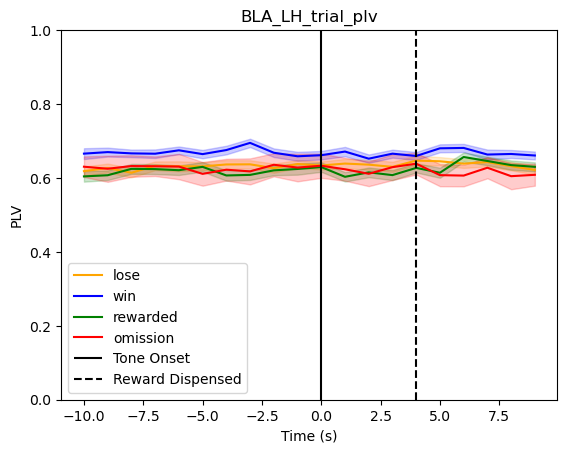

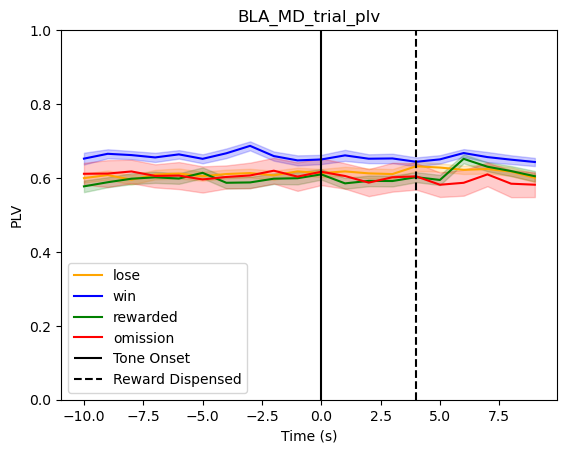

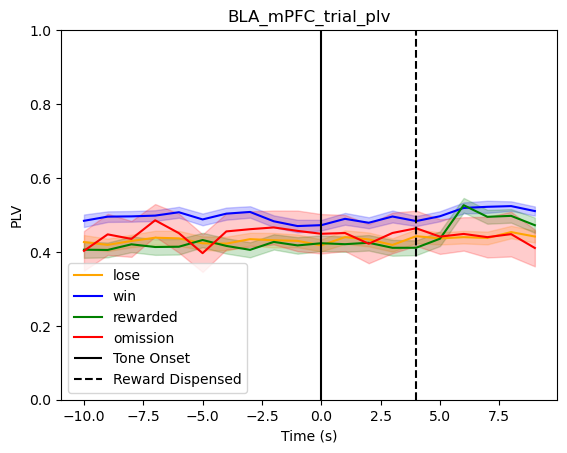

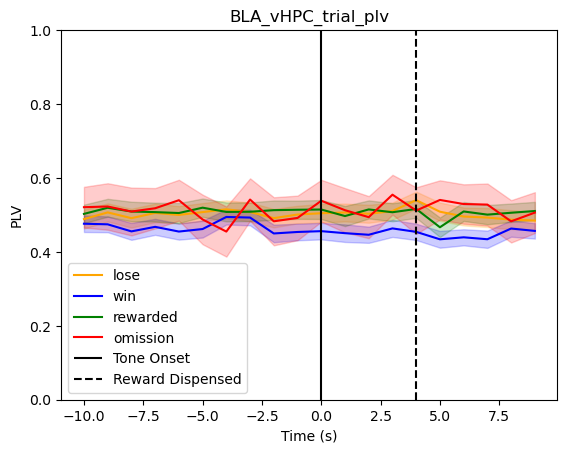

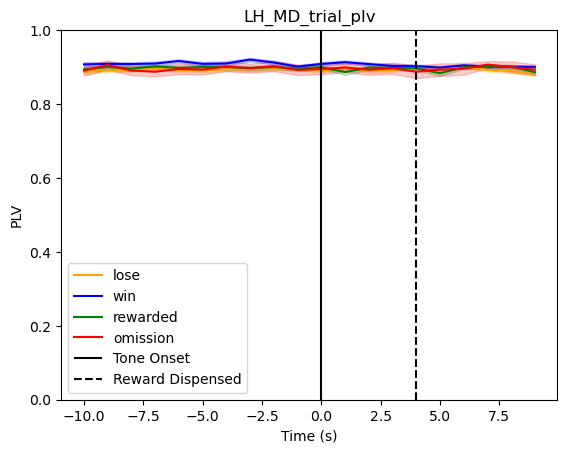

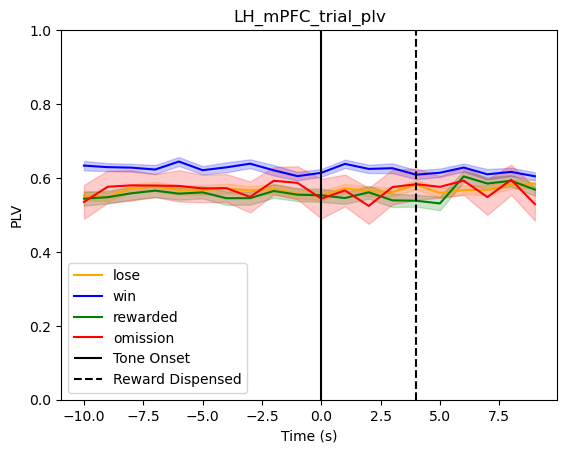

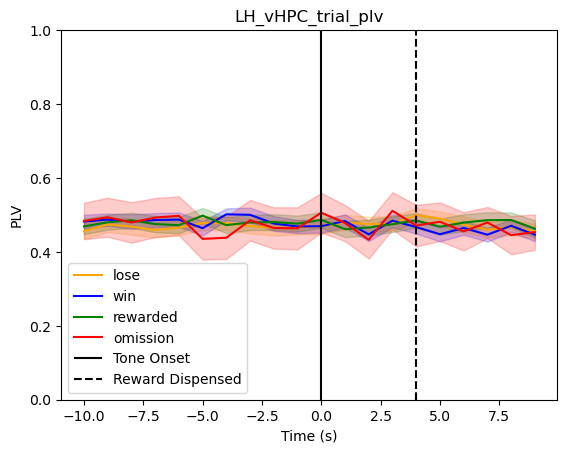

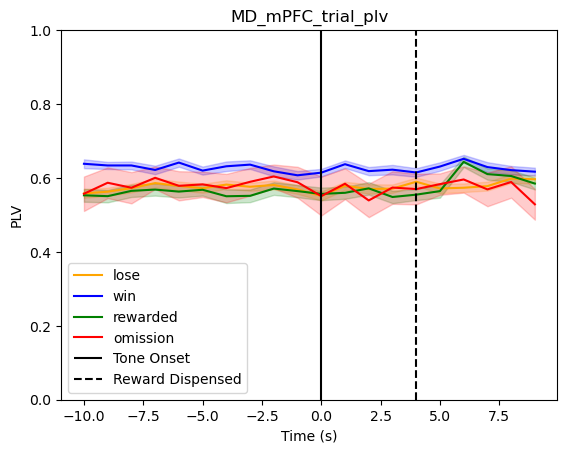

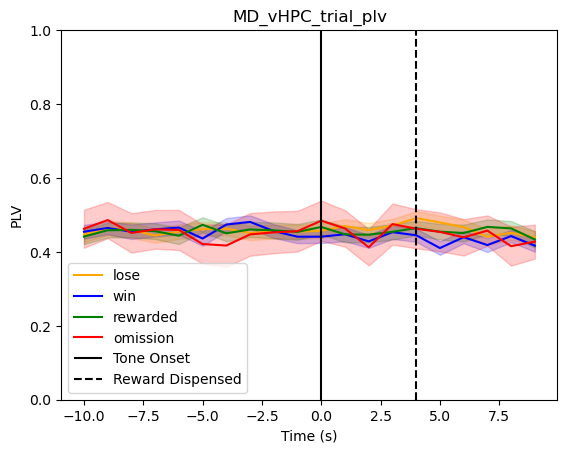

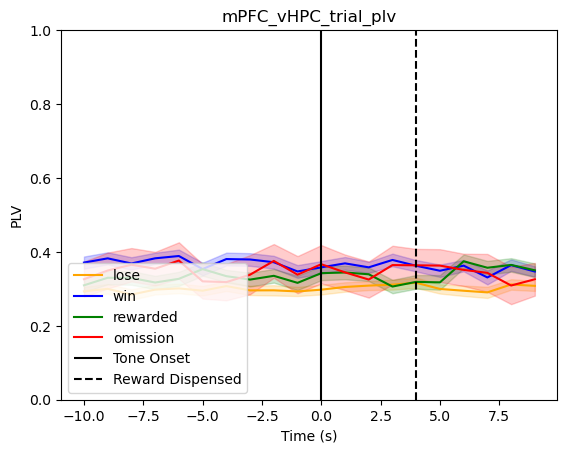

In [73]:
for baseline_col, trial_col in zip(baseline_plv_col, trial_plv_col):
    fig, ax = plt.subplots()
    current_max = 0
    current_min = 1
    for outcome in FULL_LFP_TRACES[GROUPINGS].unique():
        current_df = FULL_LFP_TRACES[(FULL_LFP_TRACES[GROUPINGS] == outcome)]
    
        # Stack all arrays vertically
        trial_arrays = np.vstack(current_df[trial_col].values)
        baseline_arrays = np.vstack(current_df[baseline_col].values)
        all_arrays = np.hstack([baseline_arrays, trial_arrays])
        
        mean = all_arrays.mean(axis=0) 
        # Compute the SEM for each index
        sem = all_arrays.std(axis=0) / np.sqrt(len(all_arrays))
        plt.plot(np.arange(-len(mean)//2, len(mean)//2), mean, label=outcome, color=BASELINE_OUTCOME_TO_COLOR[outcome])
        plt.fill_between(np.arange(-len(mean)//2, len(mean)//2), mean - sem, mean + sem, alpha=0.2, color=BASELINE_OUTCOME_TO_COLOR[outcome])
        if current_max <= mean.max():
            current_max = mean.max()
        if current_min >= mean.min():
            current_min = mean.min()
    
    # Making new ticks that are divisible by 10
    # x_ticks_range = np.arange(-len(mean), len(mean), FRAME_RATE)
    # plt.xticks(x_ticks_range)
    # Converting the x ticks into seconds
    labels = [item.get_text() for item in ax.get_xticklabels()]
    # new_labels = [str(int(label.replace('−', '-')) // FRAME_RATE)  for label in labels]
    # ax.set_xticklabels(new_labels)
    plt.vlines(x=0, ymin=0, ymax=1, label="Tone Onset", colors="black")
    plt.vlines(x=4, ymin=0, ymax=1, label="Reward Dispensed", colors="black", linestyles="--")
    
    
    plt.title("{}".format(trial_col))
    plt.xlabel("Time (s)")
    plt.ylabel('PLV')
    plt.ylim(0,1)
    plt.legend(loc="lower left")
    plt.savefig("./proc/plv/all_ylim_{}.png".format(trial_col))
    plt.show()

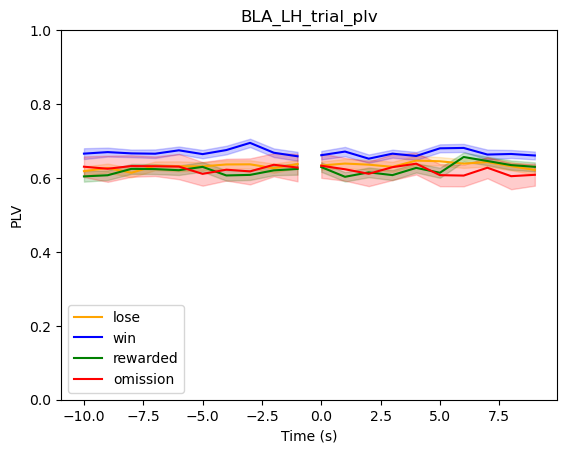

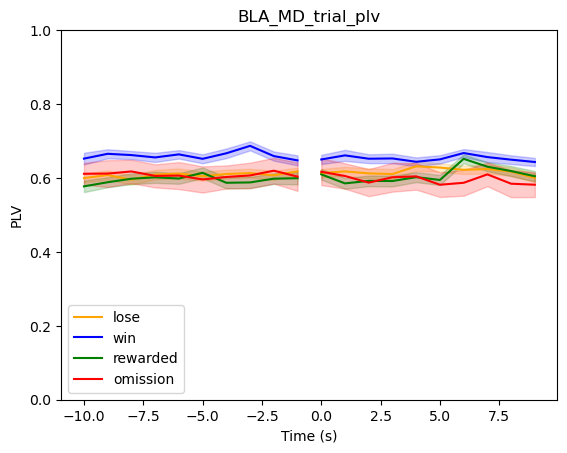

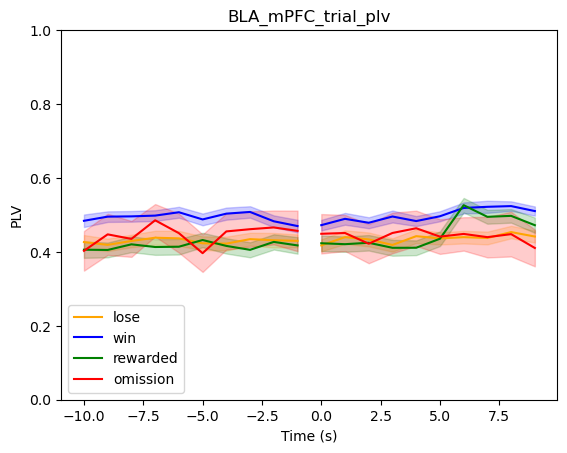

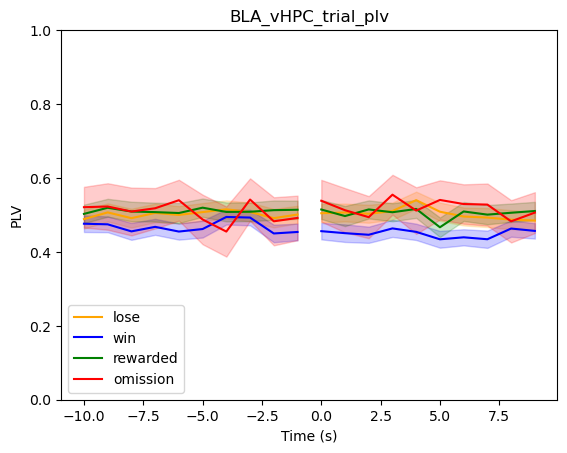

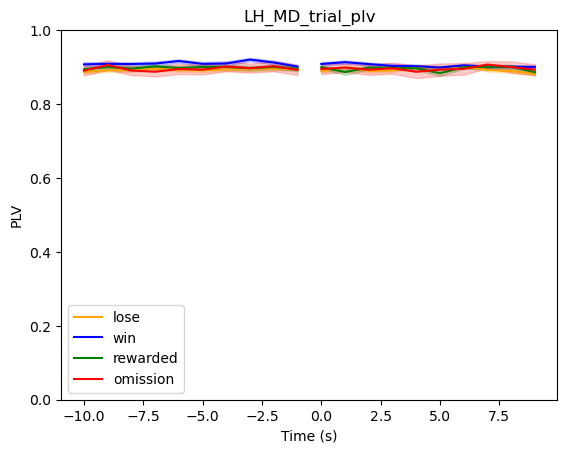

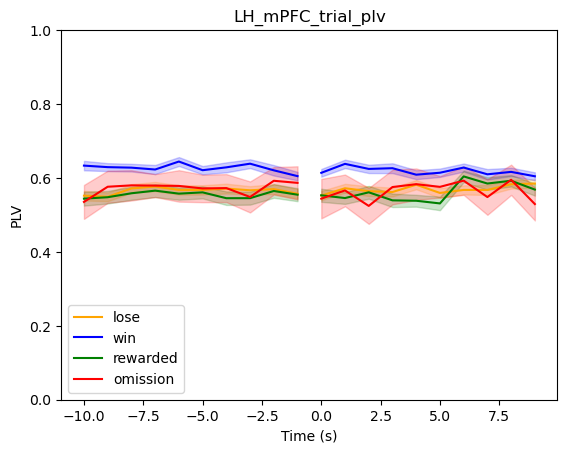

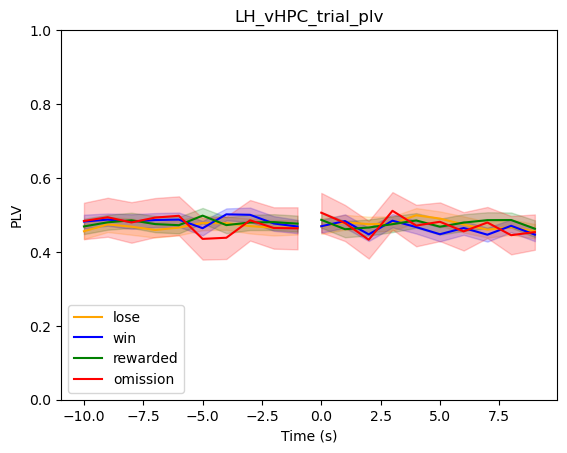

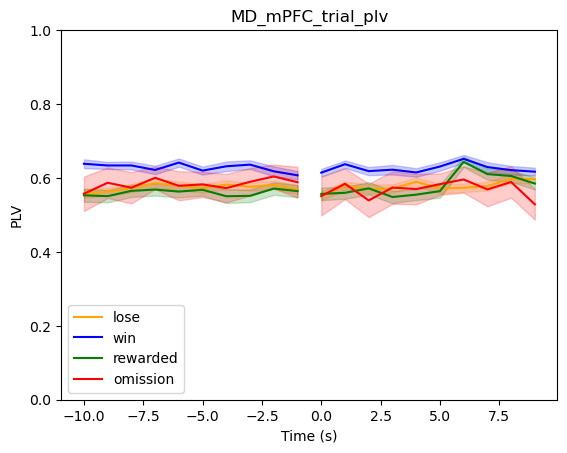

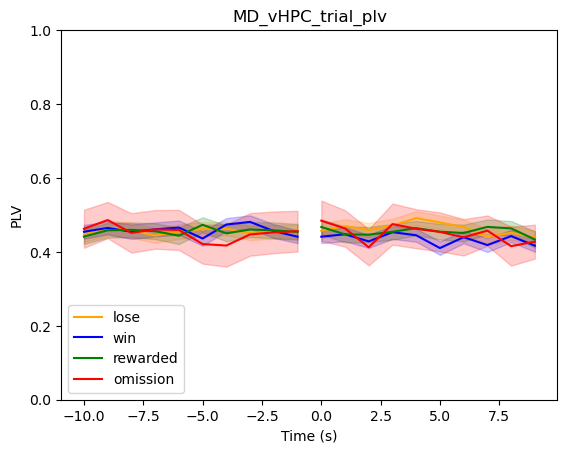

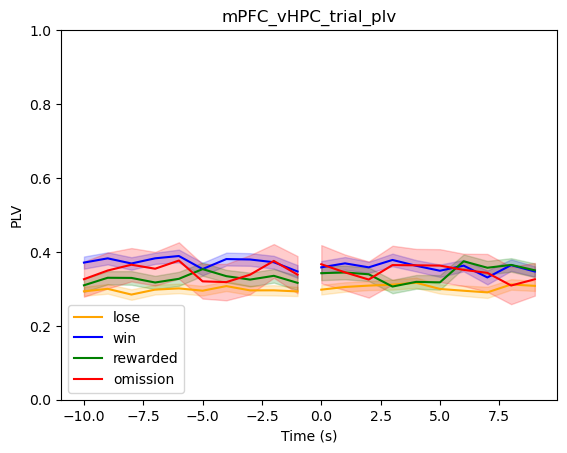

In [70]:
for baseline_col, trial_col in zip(baseline_plv_col, trial_plv_col):
    fig, ax = plt.subplots()

    for outcome in FULL_LFP_TRACES["trial_outcome"].unique():
        current_df = FULL_LFP_TRACES[(FULL_LFP_TRACES["trial_outcome"] == outcome)]
    
        # Stack all arrays vertically
        all_arrays = np.vstack(current_df[trial_col].values)
        
        
        mean = all_arrays.mean(axis=0) 
        # Compute the SEM for each index
        sem = all_arrays.std(axis=0) / np.sqrt(len(all_arrays))
        plt.plot(np.arange(len(mean)), mean, label=outcome, color=BASELINE_OUTCOME_TO_COLOR[outcome])
        plt.fill_between(np.arange(len(mean)), mean - sem, mean + sem, alpha=0.2, color=BASELINE_OUTCOME_TO_COLOR[outcome])
    
        # Stack all arrays vertically
        all_arrays = np.vstack(current_df[baseline_col].values)
        mean = all_arrays.mean(axis=0) 
        # Compute the SEM for each index
        sem = all_arrays.std(axis=0) / np.sqrt(len(all_arrays))
        plt.plot(np.arange(-len(mean), 0), mean, color=BASELINE_OUTCOME_TO_COLOR[outcome])
        plt.fill_between(np.arange(-len(mean), 0), mean - sem, mean + sem, alpha=0.2, color=BASELINE_OUTCOME_TO_COLOR[outcome])
    
    # Making new ticks that are divisible by 10
    # x_ticks_range = np.arange(-len(mean), len(mean), FRAME_RATE)
    # plt.xticks(x_ticks_range)
    # Converting the x ticks into seconds
    labels = [item.get_text() for item in ax.get_xticklabels()]
    # new_labels = [str(int(label.replace('−', '-')) // FRAME_RATE)  for label in labels]
    # ax.set_xticklabels(new_labels)
    # plt.vlines(x=0*FRAME_RATE, ymin=0, ymax=6, label="Tone Onset", colors="black")
    # plt.vlines(x=4*FRAME_RATE, ymin=0, ymax=6, label="Reward Dispensed", colors="black", linestyles="--")
    
    
    plt.title("{}".format(trial_col))
    plt.xlabel("Time (s)")
    plt.ylabel('PLV')
    plt.ylim(0,1)
    plt.legend(loc="lower left")
    # plt.savefig("./proc/all_outcome_velocity_across_trial.png")
    plt.show()

In [40]:
baseline_plv_col = sorted([col for col in FULL_LFP_TRACES.columns if "baseline_plv" in col])

In [ ]:
plv_col

In [ ]:
raise ValueError()

In [ ]:
for brain_region_pair in plv_col:
    fig, ax = plt.subplots()

    for outcome in FULL_LFP_TRACES["trial_outcome"].unique():
        current_df = FULL_LFP_TRACES[(FULL_LFP_TRACES["trial_outcome"] == outcome)]
    
        # Stack all arrays vertically
        all_arrays = np.vstack(current_df['trial_thorax_velocity'].values)
        mean = all_arrays.mean(axis=0) 
        # Compute the SEM for each index
        sem = all_arrays.std(axis=0) / np.sqrt(len(all_arrays))
        plt.plot(np.arange(len(mean)), mean, label=outcome, color=outcome_to_color[outcome])
        plt.fill_between(np.arange(len(mean)), mean - sem, mean + sem, alpha=0.2, color=outcome_to_color[outcome])
    
        # Stack all arrays vertically
        all_arrays = np.vstack(current_df['baseline_thorax_velocity'].values)
        mean = all_arrays.mean(axis=0) 
        # Compute the SEM for each index
        sem = all_arrays.std(axis=0) / np.sqrt(len(all_arrays))
        plt.plot(np.arange(-len(mean), 0), mean, color=outcome_to_color[outcome])
        plt.fill_between(np.arange(-len(mean), 0), mean - sem, mean + sem, alpha=0.2, color=outcome_to_color[outcome])
    
    # Making new ticks that are divisible by 10
    x_ticks_range = np.arange(-len(mean), len(mean), FRAME_RATE)
    plt.xticks(x_ticks_range)
    # Converting the x ticks into seconds
    labels = [item.get_text() for item in ax.get_xticklabels()]
    new_labels = [str(int(label.replace('−', '-')) // FRAME_RATE)  for label in labels]
    ax.set_xticklabels(new_labels)
    plt.vlines(x=0*FRAME_RATE, ymin=0, ymax=6, label="Tone Onset", colors="black")
    plt.vlines(x=4*FRAME_RATE, ymin=0, ymax=6, label="Reward Dispensed", colors="black", linestyles="--")
    
    
    plt.title("Velocity across time in trial")
    plt.xlabel("Time (s)")
    plt.ylabel('Velocity (cm/s)')
    
    plt.legend(loc="upper left")
    plt.savefig("./proc/all_outcome_velocity_across_trial.png")
    plt.show()

In [ ]:
fig, ax = plt.subplots()

for outcome in FULL_LFP_TRACES["trial_outcome"].unique():
    current_df = FULL_LFP_TRACES[(FULL_LFP_TRACES["trial_outcome"] == outcome)]

    # Stack all arrays vertically
    all_arrays = np.vstack(current_df['trial_thorax_velocity'].values)
    mean = all_arrays.mean(axis=0) 
    # Compute the SEM for each index
    sem = all_arrays.std(axis=0) / np.sqrt(len(all_arrays))
    plt.plot(np.arange(len(mean)), mean, label=outcome, color=outcome_to_color[outcome])
    plt.fill_between(np.arange(len(mean)), mean - sem, mean + sem, alpha=0.2, color=outcome_to_color[outcome])

    # Stack all arrays vertically
    all_arrays = np.vstack(current_df['baseline_thorax_velocity'].values)
    mean = all_arrays.mean(axis=0) 
    # Compute the SEM for each index
    sem = all_arrays.std(axis=0) / np.sqrt(len(all_arrays))
    plt.plot(np.arange(-len(mean), 0), mean, color=outcome_to_color[outcome])
    plt.fill_between(np.arange(-len(mean), 0), mean - sem, mean + sem, alpha=0.2, color=outcome_to_color[outcome])

# Making new ticks that are divisible by 10
x_ticks_range = np.arange(-len(mean), len(mean), FRAME_RATE)
plt.xticks(x_ticks_range)
# Converting the x ticks into seconds
labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [str(int(label.replace('−', '-')) // FRAME_RATE)  for label in labels]
ax.set_xticklabels(new_labels)
plt.vlines(x=0*FRAME_RATE, ymin=0, ymax=6, label="Tone Onset", colors="black")
plt.vlines(x=4*FRAME_RATE, ymin=0, ymax=6, label="Reward Dispensed", colors="black", linestyles="--")


plt.title("Velocity across time in trial")
plt.xlabel("Time (s)")
plt.ylabel('Velocity (cm/s)')

plt.legend(loc="upper left")
plt.savefig("./proc/all_outcome_velocity_across_trial.png")
plt.show()

In [ ]:
list(range(0,10))

In [ ]:
FULL_LFP_TRACES["BLA_LH_plv"].iloc[0]

In [ ]:
FULL_LFP_TRACES["LH_MD_plv"].iloc[0]

In [ ]:
for region_1, region_2 in trial_pairs:
    pair_base_name = "{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])
    print(pair_base_name)
    try:
        # 1. Compute the analytic signals
        analytic_signal1 = hilbert(lfp1)
        analytic_signal2 = hilbert(lfp2)
        
        # 2. Extract the instantaneous phases
        phase1 = np.angle(hilbert(lfp1))
        phase2 = np.angle(analytic_signal2)
        
        # 3. Compute the phase difference
        phase_diff = phase1 - phase2
        
        # 4. Calculate the PLV
        plv = abs(np.mean(np.exp(1j * phase_diff)))
    
    except Exception as e: 
        print(e)
    break

In [ ]:
lfp1 = FULL_LFP_TRACES["BLA_trial_lfp_trace"].iloc[0]
lfp2 = FULL_LFP_TRACES["MD_trial_lfp_trace"].iloc[0]

In [ ]:
import numpy as np
from scipy.signal import hilbert

# 1. Compute the analytic signals
analytic_signal1 = hilbert(lfp1)
analytic_signal2 = hilbert(lfp2)

# 2. Extract the instantaneous phases
phase1 = np.angle(analytic_signal1)
phase2 = np.angle(analytic_signal2)

# 3. Compute the phase difference
phase_diff = phase1 - phase2

# 4. Calculate the PLV
plv = abs(np.mean(np.exp(1j * phase_diff)))

print(plv)

In [ ]:
phase1

In [ ]:
phase2

In [ ]:
phase_diff

In [ ]:
phase_diff[:1000].mean()

In [ ]:
plv

In [ ]:
phase_diff[3000:4000].mean()

In [ ]:
TIME_HALFBANDWIDTH_PRODUCT = 2

In [ ]:
for region_1, region_2 in trial_pairs:
    pair_base_name = "{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])
    print(pair_base_name)
    try:
        multitaper_col = "{}_trial_multitaper".format(pair_base_name)
        FULL_LFP_TRACES[multitaper_col] = FULL_LFP_TRACES.apply(lambda x: Multitaper(time_series=np.array([x[region_1],x[region_2]]).T, sampling_frequency=RESAMPLE_RATE, time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT), axis=1)
    
        connectivity_col = "{}_trial_connectivity".format(pair_base_name)
        FULL_LFP_TRACES[connectivity_col] = FULL_LFP_TRACES[multitaper_col].apply(lambda x: Connectivity.from_multitaper(x))
        
        FULL_LFP_TRACES["{}_trial_frequencies".format(pair_base_name)] = FULL_LFP_TRACES[connectivity_col].apply(lambda x: x.frequencies)
    
        FULL_LFP_TRACES["{}_trial_phase_locking_value".format(pair_base_name)] = FULL_LFP_TRACES[connectivity_col].apply(lambda x: x.phase_locking_value()[..., 0, 1].squeeze().T)
    
    except Exception as e: 
        print(e)
    break

In [ ]:
FULL_LFP_TRACES["BLA_LH_trial_phase_locking_value"].iloc[0]

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(FULL_LFP_TRACES["BLA_LH_trial_frequencies"].iloc[0][:100], FULL_LFP_TRACES["BLA_LH_trial_phase_locking_value"].iloc[0][:100], '-o', markerfacecolor='red')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PLV')
plt.title('Phase Locking Value across Frequencies')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
FULL_LFP_TRACES["BLA_LH_trial_frequencies"].iloc[0].shape

In [ ]:
def get_multitaper(row, region_1, region_2, max_lag=3):
    """
    """
    try:
        return grangercausalitytests(np.hstack([row[region_1][np.newaxis].T, row[region_2][np.newaxis].T]), maxlag=[max_lag])[max_lag][0]["ssr_ftest"][0]
    except:
        return np.nan

In [ ]:
multitaper = Multitaper(
    signal,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=time_halfbandwidth_product,
    start_time=time[0],
)

In [ ]:
MAX_LAG = 10

In [ ]:
baseline_or_trial = "trial"
for region_1, region_2 in trial_pairs:
    region_1_name = region_1.split("_")[0]
    region_2_name = region_2.split("_")[0]
    
    
    FULL_LFP_TRACES["{}_{}_{}_granger".format(region_1_name, region_2_name, baseline_or_trial)] = FULL_LFP_TRACES.apply(lambda row: get_granger(row, region_1, region_2, max_lag=MAX_LAG), axis=1)

    FULL_LFP_TRACES["{}_{}_{}_granger".format(region_2_name, region_1_name, baseline_or_trial)] = FULL_LFP_TRACES.apply(lambda row: get_granger(row, region_2, region_1, max_lag=MAX_LAG), axis=1)

In [ ]:
baseline_or_trial = "baseline"
for region_1, region_2 in baseline_pairs:
    region_1_name = region_1.split("_")[0]
    region_2_name = region_2.split("_")[0]
    
    
    FULL_LFP_TRACES["{}_{}_{}_granger".format(region_1_name, region_2_name, baseline_or_trial)] = FULL_LFP_TRACES.apply(lambda row: get_granger(row, region_1, region_2, max_lag=MAX_LAG), axis=1)

    FULL_LFP_TRACES["{}_{}_{}_granger".format(region_2_name, region_1_name, baseline_or_trial)] = FULL_LFP_TRACES.apply(lambda row: get_granger(row, region_2, region_1, max_lag=MAX_LAG), axis=1)

In [ ]:
FULL_LFP_TRACES

In [ ]:
raise ValueError()

In [ ]:
baseline_or_trial = "baseline"
for region_1, region_2 in baseline_pairs:
    region_1_name = region_1.split("_")[0]
    region_2_name = region_2.split("_")[0]
    
    
    FULL_LFP_TRACES["{}_{}_granger".format(region_1_name, region_2_name)] = FULL_LFP_TRACES.apply(lambda row: get_granger(row, region_1, region_2), axis=1)

    FULL_LFP_TRACES["{}_{}_granger".format(region_2_name, region_1_name)] = FULL_LFP_TRACES.apply(lambda row: get_granger(row, region_2, region_1), axis=1)

    

In [ ]:
FULL_LFP_TRACES["BLA_LH_granger"].iloc[5][3][0]

In [ ]:
FULL_LFP_TRACES["LH_BLA_granger"].iloc[0][3][0]

In [ ]:
baseline_or_trial = "baseline"
for region_1, region_2 in baseline_pairs:
    region_1_name = region_1.split("_")[0]
    region_2_name = region_2.split("_")[0]

    FULL_LFP_TRACES["{}_{}_granger".format(region_1_name, region_2_name)] = FULL_LFP_TRACES.apply(lambda row: np.hstack([row[region_1][np.newaxis].T, row[region_2][np.newaxis].T]), axis=1)


    
    break
    FULL_LFP_TRACES["{}_{}_granger".format(region_1_name, region_2_name)] = FULL_LFP_TRACES.apply(lambda row: grangercausalitytests(np.hstack([row[region_1][np.newaxis].T, row[region_2][np.newaxis].T]), maxlag=[3]), axis=1)

    FULL_LFP_TRACES["{}_{}_granger".format(region_2_name, region_1_name)] = FULL_LFP_TRACES.apply(lambda row: grangercausalitytests(np.hstack([row[region_2][np.newaxis].T, row[region_1][np.newaxis].T]), maxlag=[3]), axis=1)
    break

In [ ]:
FULL_LFP_TRACES["BLA_LH_granger"].iloc[0].shape

In [ ]:
example_arr.shape

In [ ]:
example_arr = np.hstack([FULL_LFP_TRACES["BLA_trial_lfp_trace"].iloc[0][np.newaxis].T, FULL_LFP_TRACES["MD_trial_lfp_trace"].iloc[0][np.newaxis].T])

In [ ]:
example_arr = np.hstack([FULL_LFP_TRACES["MD_trial_lfp_trace"].iloc[0][np.newaxis].T, FULL_LFP_TRACES["BLA_trial_lfp_trace"].iloc[0][np.newaxis].T])

In [ ]:
grangercausalitytests(example_arr, maxlag=[3])

In [ ]:
grangercausalitytests(example_arr, maxlag=[3])

In [ ]:
region_1_name

In [ ]:
#perform Granger-Causality test
grangercausalitytests(FULL_LFP_TRACES[[baseline_pairs[0][0], baseline_pairs[0][1]]], maxlag=[3])

In [ ]:
raise ValueError()

In [ ]:
trace_columns = [col for col in channel_map_and_all_trials_df.columns if "trace" in col]

In [ ]:
trace_columns

## Power correlation between brain regions calculation

- Combining the trial/baseline and outcome label for coloring

In [ ]:
channel_map_and_all_trials_df["outcome_and_trial_or_baseline"] = channel_map_and_all_trials_df.apply(lambda x: "_".join([x["trial_outcome"], x["trial_or_baseline"]]), axis=1)

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests



In [ ]:
channel_map_and_all_trials_df.columns

In [ ]:
trace_columns = [col for col in channel_map_and_all_trials_df.columns if "trace" in col]

In [ ]:
trace_columns

In [ ]:
brain_region_pairs = generate_pairs(trace_columns)

In [ ]:
brain_region_pairs

In [ ]:
grangercausalitytests(df[['column1', 'column2']], maxlag=[3])

In [ ]:
channel_map_and_all_trials_df[region_1].iloc[0]

In [ ]:
def granger

In [ ]:
for region_1, region_2 in brain_region_pairs:
    pair_base_name = "{}_{}".format(region_1.strip("trace").strip("_"), region_2.strip("trace").strip("_"))
    print(pair_base_name)
    try:
        
        # granger_value = grangercausalitytests(channel_map_and_all_trials_df[[region_1, region_2]], maxlag=[3])
        channel_map_and_all_trials_df["{}_granger".format(pair_base_name)] = channel_map_and_all_trials_df.apply(lambda row: grangercausalitytests(np.array([row[region_1], row[region_2]]).T, maxlag=[3]), axis=1)
        print()
    except Exception as e: 
        print(e)
    break

In [ ]:
channel_map_and_all_trials_df[""]

In [ ]:
channel_map_and_all_trials_df

In [ ]:
granger_value

- Filtering out the outliers

In [ ]:
band_to_power_correlation = defaultdict(dict)
for band in ALL_BANDS:
    # Getting all the pairs of brain regions
    band_averaged_columns = [col for col in channel_map_and_all_trials_df.columns if "averaged_{}".format(band) in col]
    band_to_power_correlation[band]["brain_region_pairs"] = generate_pairs(band_averaged_columns)
    print(band_to_power_correlation[band]["brain_region_pairs"])

    # Removing rows that are outliers
    filtered_df = channel_map_and_all_trials_df.copy()
    
    for col in band_averaged_columns:
        # filtered_df = filtered_df[filtered_df[col] <= 3]
        # Assuming data is a 1D numpy array
        Q1 = np.percentile(filtered_df[col], 25)
        Q3 = np.percentile(filtered_df[col], 75)
        IQR = Q3 - Q1
        band_to_power_correlation[band]["outlier_removed_df"] = filtered_df[(filtered_df[col] >= Q1 - 1.5 * IQR) & (filtered_df[col] <= Q3 + 1.5 * IQR)]


    
    # Getting the mean and standard deviation
    

In [ ]:
band_to_power_correlation = defaultdict(dict)
for band in ALL_BANDS:
    # Getting all the pairs of brain regions
    band_averaged_columns = [col for col in channel_map_and_all_trials_df.columns if "averaged_{}".format(band) in col]
    band_to_power_correlation[band]["brain_region_pairs"] = generate_pairs(band_averaged_columns)
    print(band_to_power_correlation[band]["brain_region_pairs"])

    # Removing rows that are outliers
    filtered_df = channel_map_and_all_trials_df.copy()
    
    for col in band_averaged_columns:
        # filtered_df = filtered_df[filtered_df[col] <= 3]
        # Assuming data is a 1D numpy array
        Q1 = np.percentile(filtered_df[col], 25)
        Q3 = np.percentile(filtered_df[col], 75)
        IQR = Q3 - Q1
        filtered_df = filtered_df[(filtered_df[col] >= Q1 - 1.5 * IQR) & (filtered_df[col] <= Q3 + 1.5 * IQR)]
    band_to_power_correlation[band]["outlier_removed_df"] = filtered_df

In [ ]:
channel_map_and_all_trials_df.shape

In [ ]:
band_to_power_correlation[band]["outlier_removed_df"].shape

- Plotting all of the conditions

In [ ]:
for band in ALL_BANDS:
    for region_1, region_2 in band_to_power_correlation[band]["brain_region_pairs"]:
        region_1_basename = region_1.split("_")[0]
        region_2_basename = region_2.split("_")[0]
        x = band_to_power_correlation[band]["outlier_removed_df"][region_1]
        y = band_to_power_correlation[band]["outlier_removed_df"][region_2]
        
        # Perform linear regression to get the slope, intercept and r-value (correlation coefficient)
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        
        # Create a line of best fit using the slope and intercept
        line = slope * x + intercept
        
        # Create scatter plot
        sns.scatterplot(x=x, y=y, data=band_to_power_correlation[band]["outlier_removed_df"], hue='outcome_and_trial_or_baseline', palette=BASELINE_OUTCOME_TO_COLOR)
        
        # Plot line of best fit
        plt.plot(x, line, color='red')
        
        # Add R² value to the plot
        plt.text(0.1, 0.9, f'R = {r_value:.2f}', transform=plt.gca().transAxes)
        
        # Add labels and legend
        plt.title("Power correlation of Z-scored {} band LFP: {} and {}".format(band, region_2_basename, region_1_basename))
        plt.xlabel('{} {} power of Z-scored LFP'.format(band, region_1_basename))
        plt.ylabel('{} {} power of Z-scored LFP'.format(band, region_2_basename))
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig("./proc/power_correlation/zscored/{}/all_condition_{}_{}_power_correlation_of_zscored_{}_lfp.png".format(band, region_1_basename, region_2_basename, band))
        # Display the plot
        plt.show()




In [ ]:
raise ValueError()

In [ ]:
channel_map_and_all_trials_df = filtered_df

In [ ]:
channel_map_and_all_trials_df["trial_outcome"].unique()

In [ ]:
channel_map_and_all_trials_df["trial_or_baseline"]

In [ ]:
for band in ALL_BANDS:
    band_df = band_to_power_correlation[band]["outlier_removed_df"]
    band_to_power_correlation[band]["region_pair_to_outcome_to_r2"] = defaultdict(nested_dict)
    for outcome in band_df["trial_outcome"].unique():
        outcome_df = band_df[band_df["trial_outcome"] == outcome]
        for region_1, region_2 in brain_region_pairs:
            region_1_basename = region_1.split("_")[0]
            region_2_basename = region_2.split("_")[0]
            
            x = outcome_df[region_1]
            y = outcome_df[region_2]
            
            # Perform linear regression to get the slope, intercept and r-value (correlation coefficient)
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            # Square the r value to get the r squared value
            r2_value = r_value**2
            band_to_power_correlation[band]["region_pair_to_outcome_to_r2"]["{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])][outcome]["r"] = r_value
            band_to_power_correlation[band]["region_pair_to_outcome_to_r2"]["{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])][outcome]["std"] = std_err
            
            # Create a line of best fit using the slope and intercept
            line = slope * x + intercept
            
            # Create scatter plot
            sns.scatterplot(x=x, y=y, data=outcome_df, hue='outcome_and_trial_or_baseline', palette=BASELINE_OUTCOME_TO_COLOR, style='outcome_and_trial_or_baseline', markers=['^', 'o'])
            
            # Plot line of best fit
            plt.plot(x, line, color='red')
            
            # Add R² value to the plot
            plt.text(0.1, 0.9, f'R = {r_value:.2f}', transform=plt.gca().transAxes)
            
            # Add labels and legend
            plt.title("Power Correlation of Z-scored {} LFP: {} and {}".format(band, region_2_basename, region_1_basename))
            plt.xlabel('{} {} Power of Z-scored LFP'.format(region_1_basename, band))
            plt.ylabel('{} {} Power of Z-scored LFP'.format(region_2_basename, band))
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.savefig("./proc/power_correlation/zscored/{}/{}_{}_{}_power_correlation_of_zscored_{}_lfp.png".format(band, outcome, region_1_basename, region_2_basename, band))
            # Display the plot
            plt.show()

In [ ]:
for band in ALL_BANDS:
    # Convert the nested dictionary to a DataFrame
    data = []
    for group_name, group_data in band_to_power_correlation[band]['region_pair_to_outcome_to_r2'].items():
        for bar_name, bar_dict in group_data.items():
            data.append({"Group": group_name, "Bar": bar_name, "r": bar_dict["r"], "std": bar_dict["std"]})
    df = pd.DataFrame(data)
    
    # Create the bar plot using seaborn
    # sns.catplot(
    #     data=df, 
    #     x='Group', 
    #     y='r2', 
    #     hue='Bar', 
    #     kind='bar', 
    #     height=4, 
    #     aspect=2,
    #     legend=False,
    #     # yerr=df['std'].values,  # This line adds the SEM bars
    #     # capsize=0.1  # This line adds caps on the error bars
    # )
    
    # Create barplot
    ax = sns.barplot(x='Group', y='r', hue='Bar', data=df, ci=None)
    
    # Adding error bars
    groups = df['Group'].unique()
    bars_per_group = df['Bar'].nunique()
    bar_width = 0.8 / bars_per_group
    x_positions = []
    
    for i, group in enumerate(groups):
        num_bars = df[df['Group'] == group].shape[0]
        group_positions = np.linspace(i - bar_width*(num_bars-1)/2, i + bar_width*(num_bars-1)/2, num_bars)
        x_positions.extend(group_positions)
    
    for i, (r2, sem) in enumerate(zip(df['r'], df['std'])):
        plt.errorbar(x_positions[i], r2, yerr=sem, fmt='none', color='black', capsize=5)
    
    
    plt.xticks(rotation=90)
    plt.xlabel("Brain region pairs")
    plt.ylabel("Power correlation r")
    plt.legend(title="Trial Conditions")
    plt.title("{} Power correlations".format(band))
    plt.tight_layout()
    plt.grid()
    
    plt.savefig("./proc/power_correlation/zscored/all_zscored_{}_lfp_power_correlation.png".format(band))
    # Show the plot
    plt.show()

In [ ]:

# Convert the nested dictionary to a DataFrame
data = []
for group_name, group_data in region_pair_to_outcome_to_r2.items():
    for bar_name, bar_dict in group_data.items():
        data.append({"Group": group_name, "Bar": bar_name, "r": bar_dict["r"], "std": bar_dict["std"]})
df = pd.DataFrame(data)

# Create the bar plot using seaborn
# sns.catplot(
#     data=df, 
#     x='Group', 
#     y='r2', 
#     hue='Bar', 
#     kind='bar', 
#     height=4, 
#     aspect=2,
#     legend=False,
#     # yerr=df['std'].values,  # This line adds the SEM bars
#     # capsize=0.1  # This line adds caps on the error bars
# )

# Create barplot
ax = sns.barplot(x='Group', y='r', hue='Bar', data=df, ci=None)

# Adding error bars
groups = df['Group'].unique()
bars_per_group = df['Bar'].nunique()
bar_width = 0.8 / bars_per_group
x_positions = []

for i, group in enumerate(groups):
    num_bars = df[df['Group'] == group].shape[0]
    group_positions = np.linspace(i - bar_width*(num_bars-1)/2, i + bar_width*(num_bars-1)/2, num_bars)
    x_positions.extend(group_positions)

for i, (r2, sem) in enumerate(zip(df['r'], df['std'])):
    plt.errorbar(x_positions[i], r2, yerr=sem, fmt='none', color='black', capsize=5)


plt.xticks(rotation=90)
plt.xlabel("Brain region pairs")
plt.ylabel("Power correlation r")
plt.legend(title="Trial Conditions")
plt.title("Power correlations")
plt.tight_layout()
plt.grid()

plt.savefig("./proc/power_correlation/zscored/all_zscored_lfp_power_correlation.png")
# Show the plot
plt.show()